# 라이브러리 및 YOLO3 모델 가져오기
* OpenCV로 YOLO3 모델 로드

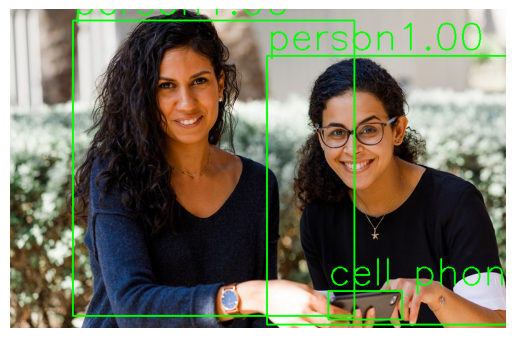

In [ ]:
import gradio as gr                          # Gradio: 웹 UI 생성을 위한 라이브러리 (현재 사용 안함)
import cv2                                   # OpenCV: 이미지 처리 및 딥러닝 모델 추론용
import numpy as np                           # NumPy: 수치 연산 및 배열 처리
import matplotlib.pyplot as plt              # 이미지 시각화를 위한 라이브러리

# YOLOv3 모델 파일 경로 지정
weights_path = "../Azure AI Vision/YOLO3/yolov3.weights"    # 학습된 가중치 / 용량이커서 깃허브에 못올림 원드라이브에 보관
config_path = "../Azure AI Vision/YOLO3/yolov3.cfg"          # 네트워크 구성 파일
names_path = "../Azure AI Vision/YOLO3/coco.names"           # 클래스 이름 파일 = 어떤거를 학습했는지

# YOLOv3 모델 불러오기
net = cv2.dnn.readNet(weights_path, config_path)            # 모델과 설정 파일을 이용해 네트워크 생성

# 클래스 이름 불러오기 (예: person, car, dog 등)
with open(names_path, 'r') as f:
    labels = f.read().strip().split('\n')                   # 각 라인을 리스트로 저장

# 객체 감지 함수 정의
def detect_objects_YOLO3(image_path):

    # 이미지 불러오기 (BGR 형식)
    image = cv2.imread(image_path)
    height, width = image.shape[:2]                         # 이미지 높이와 너비

    # 입력 이미지를 네트워크 입력(blob) 형태로 변환
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416),
                                 swapRB=True, crop=False)   # 정규화 + 크기변환 + 색상변환
    net.setInput(blob)                                      # 네트워크 입력으로 설정

    layer_names = net.getLayerNames()                       # 전체 레이어 이름 가져오기
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
                                                            # 출력 레이어(예측값이 나오는 곳) 추출

    detections = net.forward(output_layers)                 # 모델 추론 수행 → 여러 레이어 출력 반환

    boxes = []          # 바운딩 박스 좌표 저장 리스트
    confidences = []    # 신뢰도 저장 리스트
    class_ids = []      # 감지된 객체 클래스 ID 저장 리스트

    # 각 출력 레이어에 대해
    for output in detections:
        for detection in output:
            scores = detection[5:]                          # 앞 5개는 박스 좌표 + 객체 확률, 이후는 클래스 확률
            class_id = np.argmax(scores)                    # 가장 확률 높은 클래스 선택
            confidence = scores[class_id]                   # 해당 클래스의 확률

            if confidence > 0.5:                            # 감지 기준: 0.5 이상만 필터링
                box = detection[:4] * np.array([width, height, width, height])  # 원래 크기로 환산
                (center_x, center_y, w, h) = box.astype("int")                  # 중심좌표, 너비, 높이
                x = int(center_x - (w / 2))                                     # 왼쪽 상단 x좌표
                y = int(center_y - (h / 2))                                     # 왼쪽 상단 y좌표

                boxes.append([x, y, int(w), int(h)])        # 박스 좌표 저장
                confidences.append(float(confidence))       # 신뢰도 저장
                class_ids.append(class_id)                  # 클래스 ID 저장

    # 비최대 억제(NMS) 적용 → 중복 박스 제거
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    """
    YOLO 같은 모델은 하나의 객체(예: 사람 1명) 에 대해
    여러 개의 박스를 동시에 예측,
    그 이유는:
	•	서로 다른 anchor box, scale, 위치 기반으로 예측되기 때문.
	•	결과적으로 비슷한 위치에 여러 개의 박스생성함

    🧠 NMS (Non-Maximum Suppression, 비최대 억제) 중복 박스 제거란?
    이런 겹치는 박스들 중에서 가장 신뢰도 높은 것 하나만 남기고 나머지는 버리는 것
    """

    # 감지된 객체가 있을 경우 시각화
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(labels[class_ids[i]])               # 클래스 이름
            confidence = confidences[i]                     # 신뢰도

            # 바운딩 박스 그리기
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # 클래스 레이블 및 신뢰도 표시
            cv2.putText(image, f"{label}{confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

            # OpenCV는 BGR → 시각화용 RGB 변환
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image  # 감지 결과 이미지 반환

# 테스트용 이미지 감지 실행
a = detect_objects_YOLO3("../Azure AI Vision/images/people.jpg")

# 시각화
plt.axis("off")              # 좌표축 숨기기
plt.imshow(a)                # RGB 이미지 표시
plt.show()                   # 결과 출력

# ultralytics 통해서 yolov8n모델 다운로드하기
## 파라미터 기본값으로 진행


0: 640x480 4 persons, 1 bus, 1 stop sign, 52.9ms
Speed: 2.1ms preprocess, 52.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)


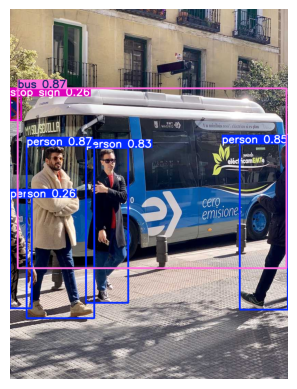

In [3]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
image = cv2.imread("../Azure AI Vision/YOLO3/images/bus.jpg")

results = model(image)

for result in results:
    result_image = result.plot()   # 박스, 클래스, 알아서 그려줌
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(result_image)
plt.show()

## 파라미터 수정할 수 있게 코드변경

📌 `results = model(image)` 설명 (Ultralytics YOLOv8)

이 코드는 **YOLOv8 객체 감지 모델에 이미지를 입력하고**,  
**추론 결과를 받아오는 핵심 줄**입니다.

---

🔍 1. 무엇을 하는가?

```python
results = model(image)
```

- `image`: `cv2.imread()` 등으로 불러온 **입력 이미지**
- `model`: `YOLO("yolov8n.pt")`로 로드된 **YOLOv8 모델**
- `results`: 모델이 감지한 **객체 정보가 담긴 리스트**

---

🧠 내부적으로 일어나는 일

1. 이미지를 **YOLO 모델에 전달**
2. YOLO가 객체 감지를 수행 (bounding box, class, confidence)
3. 결과가 `results`라는 리스트 형태로 반환됨

---

📦 `results` 안에는 무엇이 있나?

| 속성 | 설명 |
|------|------|
| `results[0]` | 한 장의 이미지에 대한 감지 결과 객체 |
| `results[0].boxes` | 감지된 객체들의 바운딩 박스 정보 |
| `boxes.xyxy` | `(x1, y1, x2, y2)` 좌표 |
| `boxes.conf` | 각 객체의 신뢰도 (0~1 사이 값) |
| `boxes.cls` | 클래스 ID (정수) |
| `model.names[class_id]` | 클래스 이름 (예: `'car'`, `'bus'`, `'person'`) |
| `result.plot()` | 감지 결과를 그린 이미지 (NumPy 배열 형태) |

---

💡 예시 흐름

```python
results = model(image)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0].item()
        cls = int(box.cls[0])
        label = model.names[cls]
```

---

✅ 요약

| 항목 | 설명 |
|------|------|
| 입력 | 이미지 (`image`) |
| 출력 | 객체 감지 결과 리스트 (`results`) |
| 핵심 기능 | YOLOv8으로 **객체 감지 수행 및 결과 반환** |


0: 640x480 4 persons, 1 bus, 1 stop sign, 62.5ms
Speed: 2.7ms preprocess, 62.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


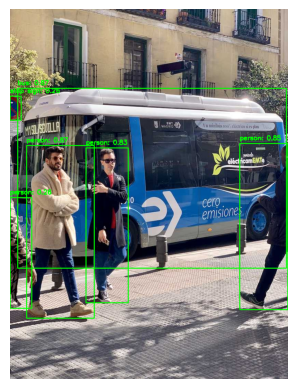

In [ ]:
from ultralytics import YOLO            # Ultralytics YOLOv8 모델 불러오기
import cv2                               # OpenCV: 이미지 처리 라이브러리
import matplotlib.pyplot as plt          # 이미지 시각화를 위한 matplotlib

# YOLOv8n 모델 로드 (n = nano, 가장 작은 모델)
model = YOLO("yolov8n.pt")               # 학습된 YOLOv8n 모델을 불러옴(다운로드)

def detect_objects_YOLO3(image_path):
    # 이미지 불러오기 (BGR 형식으로 로드됨)
    image = cv2.imread(image_path)

    # 모델을 통해 이미지에서 객체 감지 수행
    results = model(image)                   # 객체 감지 수행 → 결과 리스트 반환

    # 감지 결과 처리
    for result in results:                   # 결과는 여러 개일 수 있으므로 반복문 사용
        for box in result.boxes:             # 각 결과 내의 감지된 객체(box)들 순회
            x1, y1, x2, y2 = map(int, box.xyxy[0])     # 바운딩 박스 좌표 (왼쪽 위, 오른쪽 아래)
            confidence = box.conf[0].item()            # 해당 객체의 신뢰도 추출
            class_id = int(box.cls[0])                 # 객체 클래스 ID (예: 0 = person)
            label = model.names[class_id]              # 클래스 이름 (예: "person", "car")

            # 바운딩 박스 그리기 (녹색)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # 객체 라벨 및 신뢰도 출력
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # BGR 이미지를 RGB로 변환 (matplotlib 출력용)
    result_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return result_image

# 결과 이미지 출력
plt.axis("off")              # 축 제거
plt.imshow(result_image)     # 이미지 표시
plt.show()                   # 창 띄우기

# YOLO3 + YOLO8n + AzureAI 모델 그라디오로 구현하기

In [16]:
import gradio as gr                          
import cv2                                   
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential



weights_path = "../Azure AI Vision/YOLO3/yolov3.weights"    
config_path = "../Azure AI Vision/YOLO3/yolov3.cfg"          
names_path = "../Azure AI Vision/YOLO3/coco.names"           

# YOLOv3 모델 불러오기
net = cv2.dnn.readNet(weights_path, config_path)            

# 클래스 이름 불러오기 (예: person, car, dog 등)
with open(names_path, 'r') as f:
    labels = f.read().strip().split('\n')                   # 각 라인을 리스트로 저장

# 객체 감지 함수 정의
def detect_objects_YOLO3(image_path):

    # 이미지 불러오기 (BGR 형식)
    image = cv2.imread(image_path)
    height, width = image.shape[:2]                         # 이미지 높이와 너비

    # 입력 이미지를 네트워크 입력(blob) 형태로 변환
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416),
                                 swapRB=True, crop=False)   # 정규화 + 크기변환 + 색상변환
    net.setInput(blob)                                      # 네트워크 입력으로 설정

    layer_names = net.getLayerNames()                       # 전체 레이어 이름 가져오기
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
                                                            # 출력 레이어(예측값이 나오는 곳) 추출

    detections = net.forward(output_layers)                 # 모델 추론 수행 → 여러 레이어 출력 반환

    boxes = []          # 바운딩 박스 좌표 저장 리스트
    confidences = []    # 신뢰도 저장 리스트
    class_ids = []      # 감지된 객체 클래스 ID 저장 리스트

    # 각 출력 레이어에 대해
    for output in detections:
        for detection in output:
            scores = detection[5:]                          # 앞 5개는 박스 좌표 + 객체 확률, 이후는 클래스 확률
            class_id = np.argmax(scores)                    # 가장 확률 높은 클래스 선택
            confidence = scores[class_id]                   # 해당 클래스의 확률

            if confidence > 0.5:                            # 감지 기준: 0.5 이상만 필터링
                box = detection[:4] * np.array([width, height, width, height])  # 원래 크기로 환산
                (center_x, center_y, w, h) = box.astype("int")                  # 중심좌표, 너비, 높이
                x = int(center_x - (w / 2))                                     # 왼쪽 상단 x좌표
                y = int(center_y - (h / 2))                                     # 왼쪽 상단 y좌표

                boxes.append([x, y, int(w), int(h)])        # 박스 좌표 저장
                confidences.append(float(confidence))       # 신뢰도 저장
                class_ids.append(class_id)                  # 클래스 ID 저장

    # 비최대 억제(NMS) 적용 → 중복 박스 제거
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    """
    YOLO 같은 모델은 하나의 객체(예: 사람 1명) 에 대해
    여러 개의 박스를 동시에 예측,
    그 이유는:
	•	서로 다른 anchor box, scale, 위치 기반으로 예측되기 때문.
	•	결과적으로 비슷한 위치에 여러 개의 박스생성함

    🧠 NMS (Non-Maximum Suppression, 비최대 억제) 중복 박스 제거란?
    이런 겹치는 박스들 중에서 가장 신뢰도 높은 것 하나만 남기고 나머지는 버리는 것
    """

    # 감지된 객체가 있을 경우 시각화
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(labels[class_ids[i]])               # 클래스 이름
            confidence = confidences[i]                     # 신뢰도

            # 바운딩 박스 그리기
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # 클래스 레이블 및 신뢰도 표시
            cv2.putText(image, f"{label}{confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

            # OpenCV는 BGR → 시각화용 RGB 변환
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image  # 감지 결과 이미지 반환

# YOLOv8n 모델 로드 (n = nano, 가장 작은 모델)
model = YOLO("yolov8n.pt")               # 학습된 YOLOv8n 모델을 불러옴

def detect_objects_YOLO8n(image_path):
    # 이미지 불러오기 (BGR 형식으로 로드됨)
    image = cv2.imread(image_path)

    # 모델을 통해 이미지에서 객체 감지 수행
    results = model(image)                   # 객체 감지 수행 → 결과 리스트 반환

    # 감지 결과 처리
    for result in results:                   # 결과는 여러 개일 수 있으므로 반복문 사용
        for box in result.boxes:             # 각 결과 내의 감지된 객체(box)들 순회
            x1, y1, x2, y2 = map(int, box.xyxy[0])     # 바운딩 박스 좌표 (왼쪽 위, 오른쪽 아래)
            confidence = box.conf[0].item()            # 해당 객체의 신뢰도 추출
            class_id = int(box.cls[0])                 # 객체 클래스 ID (예: 0 = person)
            label = model.names[class_id]              # 클래스 이름 (예: "person", "car")

            # 바운딩 박스 그리기 (녹색)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # 객체 라벨 및 신뢰도 출력
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # BGR 이미지를 RGB로 변환 (matplotlib 출력용)
    result_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return result_image

# Azure AI services 엔드포인트 키값필요함
endpoint = ''
key = ''
Region = 'westeurope'

def analyze_image(image_file, mode):
    client = ImageAnalysisClient(
        endpoint=endpoint,
        credential=AzureKeyCredential(key)
    )

    visual_features_map = {
        "PEOPLE": [VisualFeatures.PEOPLE],
        "OBJECTS": [VisualFeatures.OBJECTS],
        "CAPTION": [VisualFeatures.CAPTION],
        "DENSE_CAPTIONS": [VisualFeatures.DENSE_CAPTIONS]
    }

    selected_features = visual_features_map.get(mode)

    with open(image_file, "rb") as f:
        image_data = f.read()

    result = client.analyze(
        image_data=image_data,
        visual_features=selected_features,
        gender_neutral_caption=True
    )

    img = Image.open(image_file)
    draw = ImageDraw.Draw(img)

    if mode == "PEOPLE" and result.people is not None:
        for person in result.people.list:
            if person.confidence > 0.5:
                bbox = person.bounding_box
                x1, y1 = bbox.x, bbox.y
                x2, y2 = x1 + bbox.width, y1 + bbox.height
                draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    elif mode == "OBJECTS" and result.objects is not None:
        for obj in result.objects.list:
            bbox = obj.bounding_box
            x1, y1 = bbox.x, bbox.y
            x2, y2 = x1 + bbox.width, y1 + bbox.height
            draw.rectangle([x1, y1, x2, y2], outline="blue", width=3)
            draw.text((x1 + 5, y1 + 5), obj.tags[0].name, fill="blue")

    elif mode == "CAPTION" and result.caption is not None:
        draw.text((130, 130), result.caption.text, fill="white")

    elif mode == "DENSE_CAPTIONS" and result.dense_captions is not None:
        for caption in result.dense_captions.list:
            bbox = caption.bounding_box
            x1, y1 = bbox.x, bbox.y
            x2, y2 = x1 + bbox.width, y1 + bbox.height
            draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
            draw.text((x1 + 5, y1 + 5), caption.text, fill="green")

    return img

with gr.Blocks() as demo:
    gr.Markdown("# yolo3 vs yolo8n vs Azure Custom Vision Object Detection")

    with gr.Tab("yolo3"):
        input_image_1 = gr.Image(label="입력할이미지", type="filepath")
        output_image_1 = gr.Image(label="출력할이미지", interactive=False)

        input_image_1.change(fn=detect_objects_YOLO3, inputs=[input_image_1], outputs=[output_image_1])

    with gr.Tab("yolo8n"):
        input_image_1 = gr.Image(label="입력할이미지", type="filepath")
        output_image_1 = gr.Image(label="출력할이미지", interactive=False)

        input_image_1.change(fn=detect_objects_YOLO8n, inputs=[input_image_1], outputs=[output_image_1])
    
    with gr.Tab("Azure Custom Vision Object Detection"):
         with gr.Column():
            radio = gr.Radio([
                "PEOPLE", "OBJECTS", "CAPTION", "DENSE_CAPTIONS"
            ], label="어떤 기능을 사용하시겠어요?", value="PEOPLE")

            input_image_box = gr.Image(label="입력이미지", type="filepath")
            submit_button = gr.Button("제출")
            output_image_box = gr.Image(label="출력이미지", interactive=False)

            submit_button.click(fn=analyze_image, inputs=[input_image_box, radio], outputs=[output_image_box])

demo.launch()

* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.
